# Toy REINFORCE playground

https://github.com/PacktPublishing/Reinforcement-Learning-Algorithms-with-Python/blob/master/Chapter06/REINFORCE_baseline.py

Improvements:

- 1
- 2
- ...

In [730]:
import random
from itertools import accumulate

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

In [731]:
torch.cuda.is_available()

True

## Utilities

In [732]:
GAMMA = 0.99

In [733]:
def calculate_qvals(rewards: list[float], gamma: float = GAMMA) -> np.ndarray:
    return np.array(
        list(reversed(list(accumulate(reversed(rewards), lambda x, y: gamma * x + y))))
    )

## Environment

In [734]:
class BlackJack:
    def _get_reward(self) -> float:
        if self.score < self.win_score:
            return self.step_penalty
        if self.score == self.win_score:
            return self.win_reward
        return self.loose_reward

    def __init__(self) -> None:
        self.actions_dict = {0: 1, 1: 5, 2: 10}

        self.win_score = 101

        self.win_reward = 100
        self.step_penalty = -1
        self.loose_reward = 0

        self.reset()

    def reset(self) -> list[int]:
        # self.score = random.randint(0, self.win_score - 1)
        self.score = 85
        self.steps = 0
        return [self.score]

    def get_state(self) -> list[int]:
        return [self.score]

    def is_terminal(self) -> bool:
        return self.score >= self.win_score

    def interact(self, action: int) -> tuple[list[int], float, bool]:
        if self.is_terminal():
            return [self.score], 0, self.is_terminal()
        self.score += self.actions_dict[action]
        self.steps += 1

        return [self.score], self._get_reward(), self.is_terminal()

    def get_observation_shape(self) -> int:
        return 1

    def get_actions_shape(self) -> int:
        return len(self.actions_dict)

In [735]:
test_env = BlackJack()
print(test_env.interact(2))
print(test_env.interact(1))
print(test_env.interact(0))
print(test_env.is_terminal())

([95], -1, False)
([100], -1, False)
([101], 100, True)
True


## Policy Gradient Network

In [736]:
class PGN(nn.Module):
    def __init__(self, input_dim: int, output_dim: int, hidden_dim: int = 16) -> None:
        super(PGN, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.net(x)

## Agent

In [737]:
action_logits = torch.FloatTensor([1, 2, 3])
print(F.softmax(action_logits, dim=0))
random.choices(range(len(action_logits)), F.softmax(action_logits, dim=0))[0]

tensor([0.0900, 0.2447, 0.6652])


2

In [738]:
class Agent:
    def choose_action(self, action_logits):
        return random.choices(range(len(action_logits)), F.softmax(action_logits, dim=0))[
            0
        ]

## Trajectory Buffer

In [739]:
class TrajectoryBuffer:
    """
    Buffer class to store the experience from a unique policy
    """

    def __init__(self):
        self.states = []
        self.actions = []
        self.rewards = []
        self.discounted_rewards = []
        self.discounted_baseline_rewards = []

    def store(self, states_trajectory: np.ndarray, trajectory: np.ndarray):
        """
        Add trajectory values to the buffers and compute the advantage and reward to go

        Parameters:
        -----------
        states_trajectory:  list that contains states
        trajectory: list where each element is a list that contains: reward, action
        """
        assert len(states_trajectory) == len(trajectory)

        if len(states_trajectory) > 0:
            self.states.extend(states_trajectory)
            self.rewards.extend(trajectory[:, 0])
            discounted_rewards = calculate_qvals(trajectory[:, 0])

            # BASELINE
            # b = trajectory[:,0].mean() # avg for rewards in trajectory
            b = np.mean(self.rewards)  # avg for all rewards in episode

            self.actions.extend(trajectory[:, 1])
            self.discounted_rewards.extend(discounted_rewards)
            self.discounted_baseline_rewards.extend(discounted_rewards - b)
            # self.discounted_baseline_rewards.extend((discounted_rewards - np.mean(discounted_rewards))/(np.std(discounted_rewards) + 1e-10))

    def get_batch(self):
        return self.states, self.actions, self.discounted_baseline_rewards

    def __len__(self):
        assert (
            len(self.states)
            == len(self.actions)
            == len(self.discounted_baseline_rewards)
            == len(self.discounted_rewards)
        )
        return len(self.states)

## Training

In [740]:
LEARNING_RATE = 0.001

env = BlackJack()
net = PGN(input_dim=env.get_observation_shape(), output_dim=env.get_actions_shape())
agent = Agent()
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

In [741]:
EPOCHS = 200
STEPS_PER_EPOCH = 100

ENTROPY_BETA = 0.0

In [742]:
step_count = 0
train_rewards = []
train_ep_len = []

mean_epoch_rewards = []
mean_epoch_ep_len = []
epoch_loss = []
epoch_entropy = []

probs = []

loop = tqdm(range(EPOCHS), desc="Epoch")

for _ in loop:
    state = env.reset()
    buffer = TrajectoryBuffer()
    env_states_buf, env_rew_act_buf = [], []
    ep_rewards = []

    train_logs_shift = len(train_rewards)  # for logging

    while len(buffer) < STEPS_PER_EPOCH:
        with torch.no_grad():
            action_logits = net(torch.FloatTensor(state))

            action = agent.choose_action(action_logits)
            state2, reward, done = env.interact(action)

            env_states_buf.append(state.copy())
            env_rew_act_buf.append([reward, int(action)])

            state = state2.copy()

            step_count += 1
            ep_rewards.append(reward)

            if done:
                buffer.store(np.array(env_states_buf), np.array(env_rew_act_buf))
                env_states_buf, env_rew_act_buf = [], []

                train_rewards.append(np.sum(ep_rewards))
                train_ep_len.append(len(ep_rewards))

                state = env.reset()
                ep_rewards = []

    state_batch, action_batch, reward_batch = buffer.get_batch()

    optimizer.zero_grad()
    states_t = torch.FloatTensor(np.array(state_batch))
    batch_actions_t = torch.LongTensor(action_batch)
    batch_qvals_t = torch.FloatTensor(reward_batch)

    logits_v = net(states_t)
    log_prob_v = F.log_softmax(logits_v, dim=1)

    log_prob_actions_v = batch_qvals_t * log_prob_v[range(len(states_t)), batch_actions_t]
    loss_policy_v = -log_prob_actions_v.mean()

    prob_v = F.softmax(logits_v, dim=1)
    probs.append(prob_v.detach().numpy())
    entropy_v = -(prob_v * log_prob_v).sum(dim=1).mean()
    entropy_loss_v = -ENTROPY_BETA * entropy_v
    loss_v = loss_policy_v + entropy_loss_v

    loss_v.backward()

    nn.utils.clip_grad_norm_(net.parameters(), 1.0, norm_type=2)
    optimizer.step()

    # logging
    mean_epoch_rewards.append(np.mean(train_rewards[train_logs_shift:]))
    mean_epoch_ep_len.append(np.mean(train_ep_len[train_logs_shift:]))
    epoch_loss.append(loss_v.item())
    epoch_entropy.append(entropy_v.item())

    loop.set_postfix(
        {
            "Mean reward": mean_epoch_rewards[-1],
            "Mean ep len": mean_epoch_ep_len[-1],
            "Mean Loss": epoch_loss[-1],
            "Mean Entropy": epoch_entropy[-1],
        }
    )
    # if epoch_loss[-1] < 0:
    #     print(loss_v.item())
    #     break

Epoch: 100%|██████████| 200/200 [00:08<00:00, 23.37it/s, Mean reward=-1, Mean ep len=2, Mean Loss=-1.55e-6, Mean Entropy=6.73e-5]   


In [745]:
np.max(mean_epoch_rewards)

-1.0

In [743]:
def get_uniform_entropy(n_actions: int):
    probs = np.array([1 / n_actions for _ in range(n_actions)])
    return -np.sum(probs * np.log(probs))


uniform_entropy = get_uniform_entropy(env.get_actions_shape())
uniform_entropy

1.0986122886681096

[]

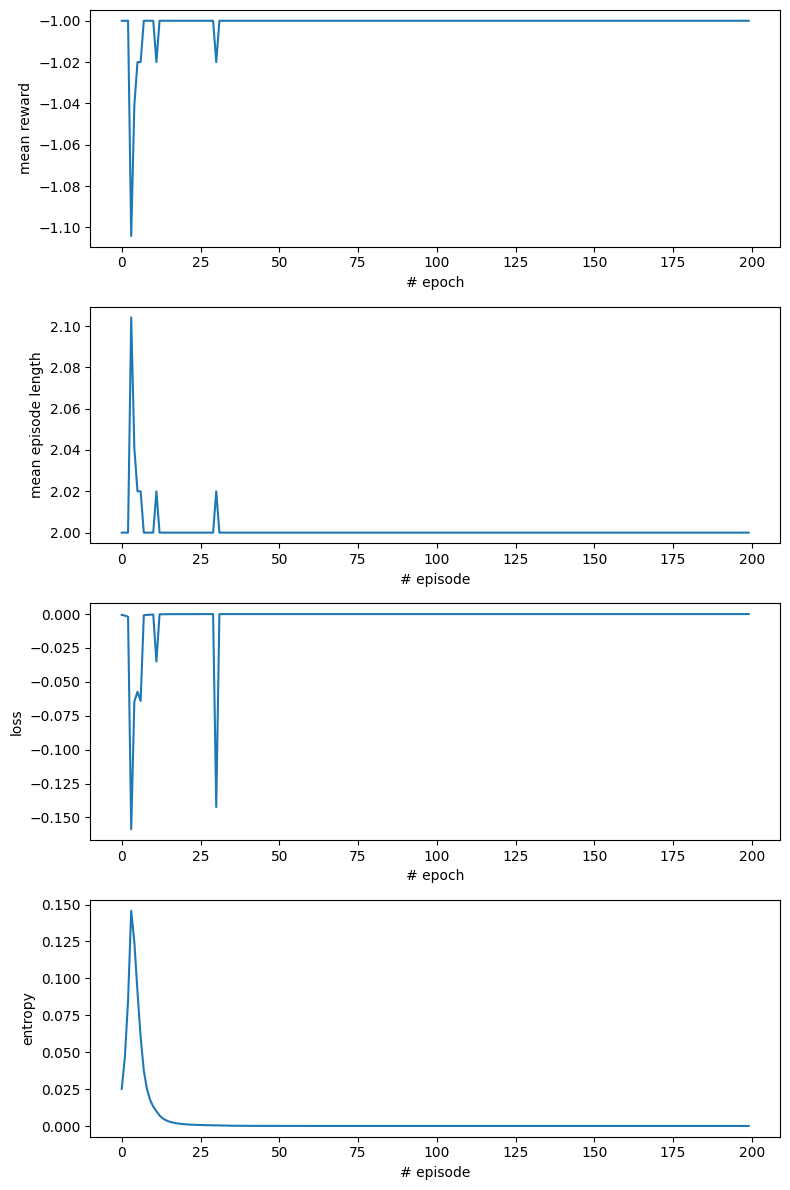

In [744]:
fig, axs = plt.subplots(4, 1, figsize=(8, 12))

# Mean Reward per epoch
axs[0].plot(range(EPOCHS), mean_epoch_rewards)
axs[0].set_xlabel("# epoch")
axs[0].set_ylabel("mean reward")

# Mean Episode length per epoch
axs[1].plot(range(EPOCHS), mean_epoch_ep_len)
axs[1].set_xlabel("# episode")
axs[1].set_ylabel("mean episode length")


# Epoch loss
axs[2].plot(range(EPOCHS), epoch_loss)
axs[2].set_xlabel("# epoch")
axs[2].set_ylabel("loss")

# Epoch entropy
axs[3].plot(range(EPOCHS), epoch_entropy)
# axs[3].plot(range(EPOCHS), [uniform_entropy]*EPOCHS)
axs[3].set_xlabel("# episode")
axs[3].set_ylabel("entropy")

plt.tight_layout()
plt.plot()